# EFAS - atributos
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 19-08-2023*<br>

**Introducción:**<br>
En este _notebook_ se va a crear una nueva tabla de atributos de las subcuencas del conjunto de datos CAMELS-ESP.

Como se vio en otro [notebook](Caravan_explorar_dataset.ipynb), al ejecutar los códigos de CARAVAN se crearon 3 tablas de atributos de las subcuencas de CAMELS-ESP. La idea aquí es replicar estas tablas, pero con información extraída de los mapas estáticos de EFASv5.

**Ideas:**<br>
* [ ] ¿Añadir área y volumen de los ríos?
* [ ] 

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm
import yaml
from pathlib import Path

from funciones import *

In [2]:
def plot_atributos(df: pd.DataFrame, x: pd.Series, y: pd.Series, save: Path = None, **kwargs):
    """
    """

    # kwargs
    figsize = kwargs.get('figsize', (5, 4))
    ncols_max = kwargs.get('ncols', 3)
    cmap = kwargs.get('cmap', 'magma')
    alpha = kwargs.get('alpha', 1)
   
    proj = ccrs.PlateCarree()
    ncols, nrows = df.shape[1], 1
    if ncols > ncols_max:
        ncols, nrows = ncols_max, int(np.ceil(ncols / ncols_max))

    fig, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             figsize=(figsize[0] * ncols, figsize[1] * nrows),
                             subplot_kw={'projection': proj})
    for i, col in enumerate(df.columns):
        if nrows > 1:
            f, c = i // ncols, i % ncols
            ax = axes[f, c]
        else:
            c = i
            ax = axes[c]
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
        ax.set_extent(kwargs.get('extent', [-9.5, 3.5, 36, 44.5]), crs=proj)
        sc = ax.scatter(x[df.index], y[df.index], cmap=cmap, c=df[col], s=5, alpha=alpha, label=col)
        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', shrink=.5)
        ax.set_title(' '.join(col.split('_')))
        ax.axis('off');
    
    if c < ncols - 1:
        for c_ in range(c + 1, ncols):
            axes[f, c_].axis('off')

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

## Configuración

In [6]:
with open("config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path('../../data/anuario_aforos/')
path_efas = Path(cfg['rutas'].get('EFAS', '../../data/EFASv5/'))
path_caravan = Path(cfg['rutas'].get('caravan', '../../data/caravan/'))

# # directorios con los datos de EFAS
# path_EFAS = 'C:/Users/jcr693/Documents/EFASv5/'
# path_maps = f'{path_EFAS}iberia/maps/'
# path_tables = f'{path_EFAS}iberia/tables/'

# # directorio con las capas GIS
# path_GIS = '../data/anuario_aforos/GIS/'

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = Path('../../data/EFASv5/atributos/')
if os.path.exists(path_out) is False:
    os.mkdir(path_out)

## Subcuencas

In [10]:
# cargar subcuencas
subcuencas = gpd.read_file(path_anuario / 'GIS/subcuencas_epsg4326.shp')
subcuencas.set_index('gauge_id', drop=False, inplace=True)
print('nº de subcuencas: {0}'.format(subcuencas.shape[0]))

KeyError: "None of ['gauge_id'] are in the columns"

### Estaciones 

In [8]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)
estaciones = estaciones.loc[subcuencas.index]

n_estaciones = estaciones.shape[0]
print('nº de estaciones en la capa de puntos:\t{0}'.format(n_estaciones))

KeyError: 'None of [RangeIndex(start=0, stop=355, step=1)] are in the [index]'

In [ ]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.3)
ax.scatter(estaciones.geometry.x, estaciones.geometry.y, c='steelblue', s=5, alpha=1, label='Anuario')
ax.axis('off');

## Mapas estáticos

In [7]:
# cargar mapa de áreas de cada celda, que será utilizado en ciertos cálculos
pixarea = read_static_map(f'{path_efas}/maps/pixarea*.nc', var='Band1')

# cargar mapa de áreas de cada celda, que será utilizado en ciertos cálculos
upArea = read_static_map(f'{path_efas}/maps/upArea*.nc', var='Band1')

### Geomorfología

In [8]:
maps = {'elv': ['mean', 'std', 'min', 'max'], # la desviación estándar no se incluye en Caravan
        'gradient': ['mean', 'std'], # la desviación estándar no se incluye en Caravan
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# cargar mapas
geomorfologia = xr.Dataset({var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var='Band1') for var in maps})
geomorfologia = geomorfologia.drop('crs')

# calcular estadísticos
geomorfologia = geomorfologia.rio.write_crs(crs)
atributos_geomorfologia = polygon_statistics(geomorfologia, subcuencas, func=maps).to_pandas()

atributos_geomorfologia.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,elv_mean,elv_std,elv_min,elv_max,gradient_mean,gradient_std,upArea_max
id,,,,,,,
3278,452.258453,53.047913,340.343384,584.204712,0.017296,0.012407,1.752919e+08
3169,373.864960,61.912193,212.873779,740.192444,0.011127,0.009867,1.965000e+09
3253,340.378235,51.071892,212.873779,460.770996,0.009773,0.005615,1.965000e+09
3246,409.179749,41.623402,345.186951,539.734802,0.010850,0.010405,2.954176e+08
3163,463.727142,177.396301,229.426239,1133.390137,0.027571,0.029381,9.681178e+08


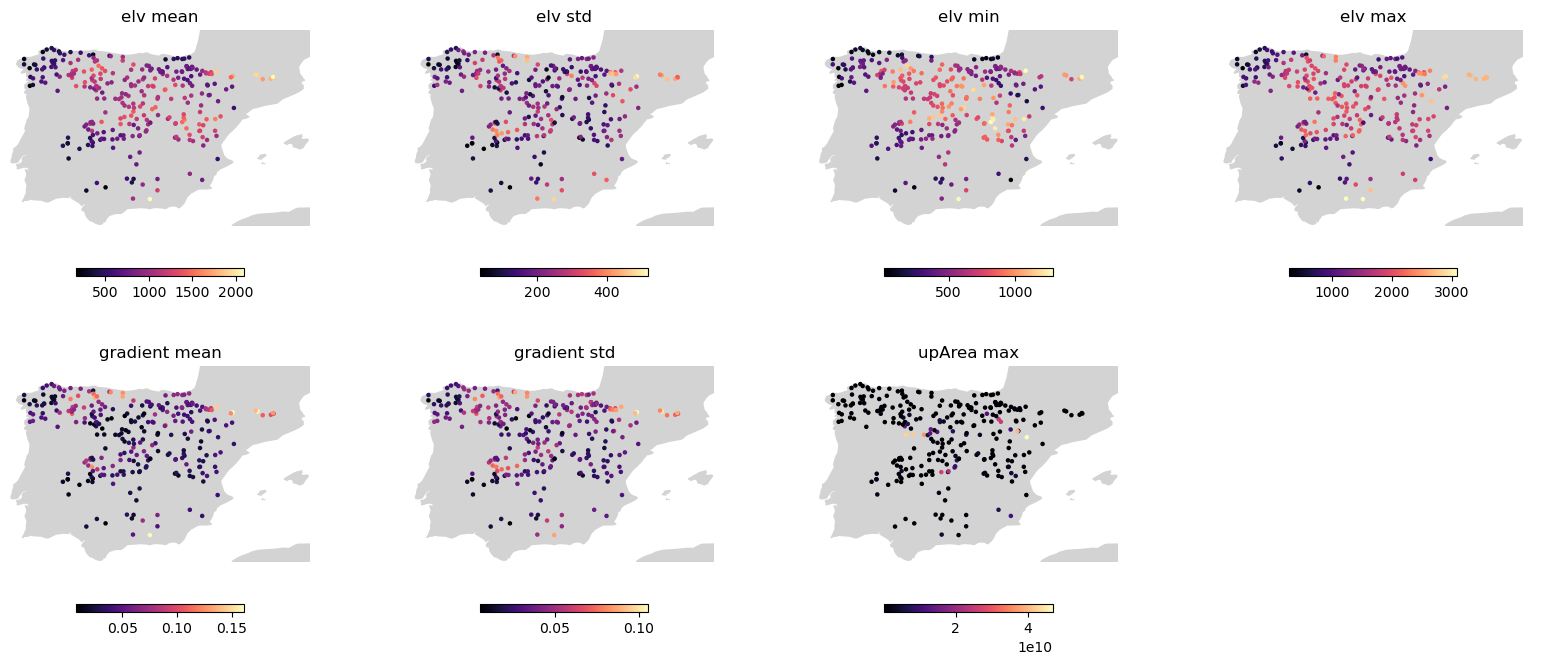

In [9]:
plot_atributos(atributos_geomorfologia, estaciones.geometry.x, estaciones.geometry.y, ncols=4)

### Usos del suelo 

In [10]:
vars = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']
vars.sort()

# cargar mapas
uso_suelo = xr.Dataset({var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var='Band1') for var in vars})
uso_suelo = uso_suelo.drop('crs')
# uso_suelo = uso_suelo.rename({var: var[4:] for var in list(uso_suelo)})

# multiplicar por el área de cada celda
# uso_suelo *= pixarea

# calcular estadísticos
uso_suelo = uso_suelo.rio.write_crs(crs)
atributos_usos = polygon_statistics(uso_suelo, subcuencas, func='mean').to_pandas()
atributos_usos.sort_index(axis=1, inplace=True)

# calcular la clase mayoritaria
lu_classes = {col: i for i, col in enumerate(atributos_usos.columns, start=1)}
atributos_usos['lu_majority'] = atributos_usos.idxmax(axis=1).map(lu_classes)

atributos_usos.rename(columns={col: col.split('_')[0] if 'mean' in col else 'land_use_main' for col in atributos_usos}, inplace=True)

atributos_usos.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,fracforest,fracirrigated,fracother,fracrice,fracsealed,fracwater,land_use_main
id,,,,,,,
3278,0.153439,0.001497,0.831321,0.0,0.012192,0.001551,3
3169,0.135701,0.006515,0.847372,0.0,0.008189,0.002224,3
3253,0.045769,0.000000,0.949207,0.0,0.004287,0.000737,3
3246,0.149541,0.007263,0.832833,0.0,0.005667,0.004696,3
3163,0.293368,0.000629,0.703026,0.0,0.002689,0.000288,3


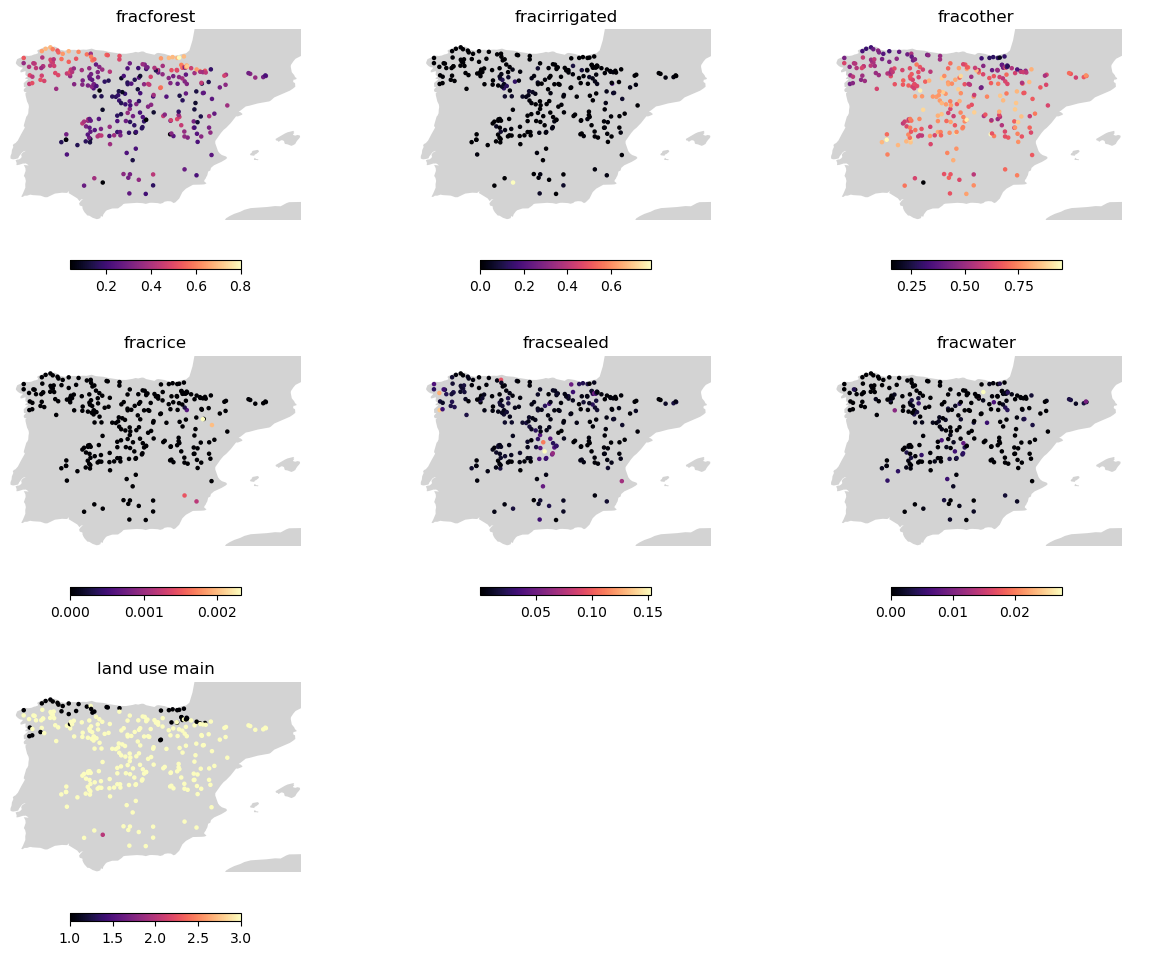

In [11]:
plot_atributos(atributos_usos, estaciones.geometry.x, estaciones.geometry.y, ncols=3)

### Coeficiente de cultivo

In [12]:
# convertsión de siglas con el uso del suego
mapping_usos = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}

vars = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# cargar mapas
cultivo = xr.Dataset({var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var='Band1') for var in vars})
cultivo = cultivo.rename({var: mapping_usos[var.split('_')[1]] for var in list(cultivo)})
# media ponderada por la fracción cubierta por cada uso del suelo
cultivo = cultivo.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
cultivo = cultivo.where(~upArea.isnull())
cultivo.name = 'cropcoef'
cultivo = cultivo.drop('crs')

# calcular estadísticos
cultivo = cultivo.rio.write_crs(crs)
cultivo = cultivo.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
atributos_cultivo = polygon_statistics(cultivo, subcuencas, func=['mean', 'std']).to_pandas()

atributos_cultivo.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,cropcoef_mean,cropcoef_std
id,,
3278,0.0,0.0
3169,0.0,0.0
3253,0.0,0.0
3246,0.0,0.0
3163,0.0,0.0


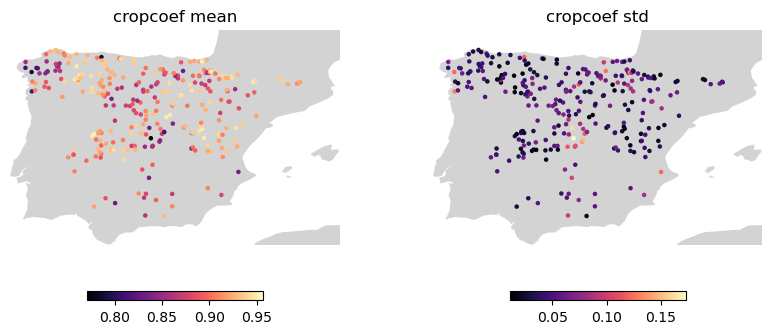

In [13]:
plot_atributos(atributos_cultivo, estaciones.geometry.x, estaciones.geometry.y, ncols=4)

### Cauces

  0%|          | 0/287 [00:00<?, ?it/s]

,chanbnkf_mean,chanbw_mean,changrad_mean,chanlength_sum,chanman_mean
id,,,,,
3278,1.204117,0.000000,0.016106,16388.781250,0.039548
3169,1.851063,14.971615,0.004984,206516.843750,0.034122
3253,1.427283,0.661765,0.006472,26996.017578,0.035933
3246,1.532665,0.000000,0.002034,24081.406250,0.034666
3163,1.781429,0.000000,0.008810,106556.445312,0.034513


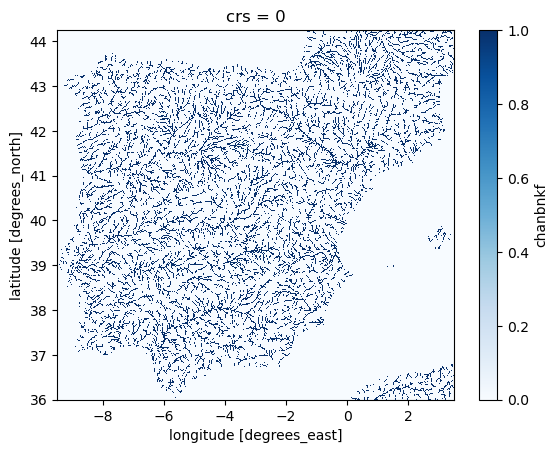

In [13]:
maps = {'chanbnkf': ['mean'],
        'chanbw': ['mean'],
        'changrad': ['mean'],
        'chanlength': ['sum'],
        'chanman': ['mean']}

# cargar y reordenar los mapas
cauces = {var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var='Band1') for var in maps}
cauces = {var: da.rename(var) for var, da in cauces.items()}
cauces = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in cauces.items()}
cauces = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in cauces.items()})

# enmascarar los cauces (celdas con calado mayor de 1 m)
rios = cauces['chanbnkf'] > 1
rios.plot(cmap='Blues')
cauces = cauces.where(rios)

# calcular estadístico
cauces = cauces.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
cauces = cauces.rio.write_crs(crs)
atributos_cauces = polygon_statistics(cauces, subcuencas, func=maps).to_pandas()

atributos_cauces.head()

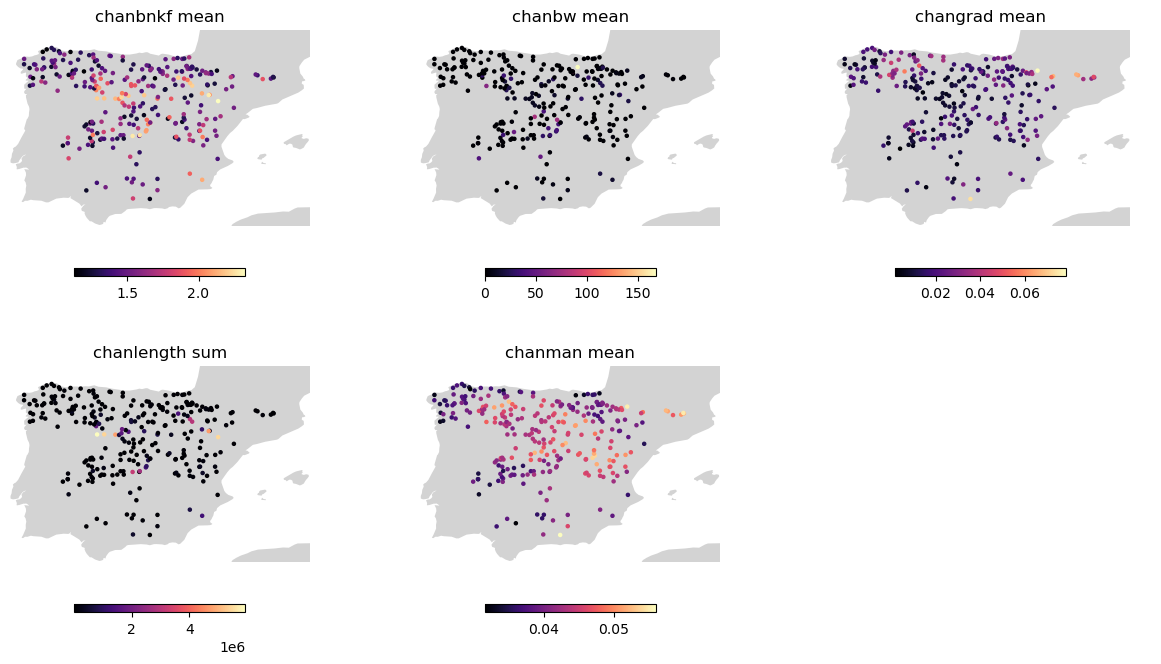

In [14]:
plot_atributos(atributos_cauces, estaciones.geometry.x, estaciones.geometry.y)

### Suelos 

In [16]:
vars = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in vars for layer in layers]

# cargar mapas
suelos = {}
for var in tqdm(maps):
    files = glob.glob(f'{path_efas}/maps/{var}_*.nc')
    if len(files) > 1:
        ds = {}
        for file in files:
            # tipo de cobertura del suelo
            cover = mapping_usos[file.split('\\')[-1].split('_')[1]]
            # importar datos
            ds[cover] = read_static_map(file)
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        da = da.drop('crs')
        suelos[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        suelos[var] = read_static_map(files[0])
suelos = xr.Dataset(suelos)
suelos = suelos.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
suelos = suelos.rio.write_crs(crs)
# suelos = suelos.drop('crs')

# calcular estadístico
atributos_suelos = polygon_statistics(suelos, subcuencas, func='mean').to_pandas

atributos_suelos.rename(columns={col: col.split('_')[0] for col in atributos_suelos if 'mean' in col}, inplace=True)

atributos_suelos.head()

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

,ksat1_mean,ksat2_mean,ksat3_mean,lambda1_mean,lambda2_mean,lambda3_mean,genua1_mean,genua2_mean,genua3_mean,soildepth1_mean,soildepth2_mean,soildepth3_mean,thetas1_mean,thetas2_mean,thetas3_mean,thetar1_mean,thetar2_mean,thetar3_mean
id,,,,,,,,,,,,,,,,,,
3278,0.0,0.0,123.692764,0.0,0.0,0.371926,0.0,0.0,0.020331,0.0,0.0,0.0,0.0,0.0,0.390074,0.041,0.041,0.041
3169,0.0,0.0,103.957817,0.0,0.0,0.343740,0.0,0.0,0.016143,0.0,0.0,0.0,0.0,0.0,0.385502,0.041,0.041,0.041
3253,0.0,0.0,104.967667,0.0,0.0,0.345356,0.0,0.0,0.016311,0.0,0.0,0.0,0.0,0.0,0.385687,0.041,0.041,0.041
3246,0.0,0.0,99.086304,0.0,0.0,0.337096,0.0,0.0,0.015175,0.0,0.0,0.0,0.0,0.0,0.385758,0.041,0.041,0.041
3163,0.0,0.0,122.533234,0.0,0.0,0.371794,0.0,0.0,0.019955,0.0,0.0,0.0,0.0,0.0,0.393442,0.041,0.041,0.041


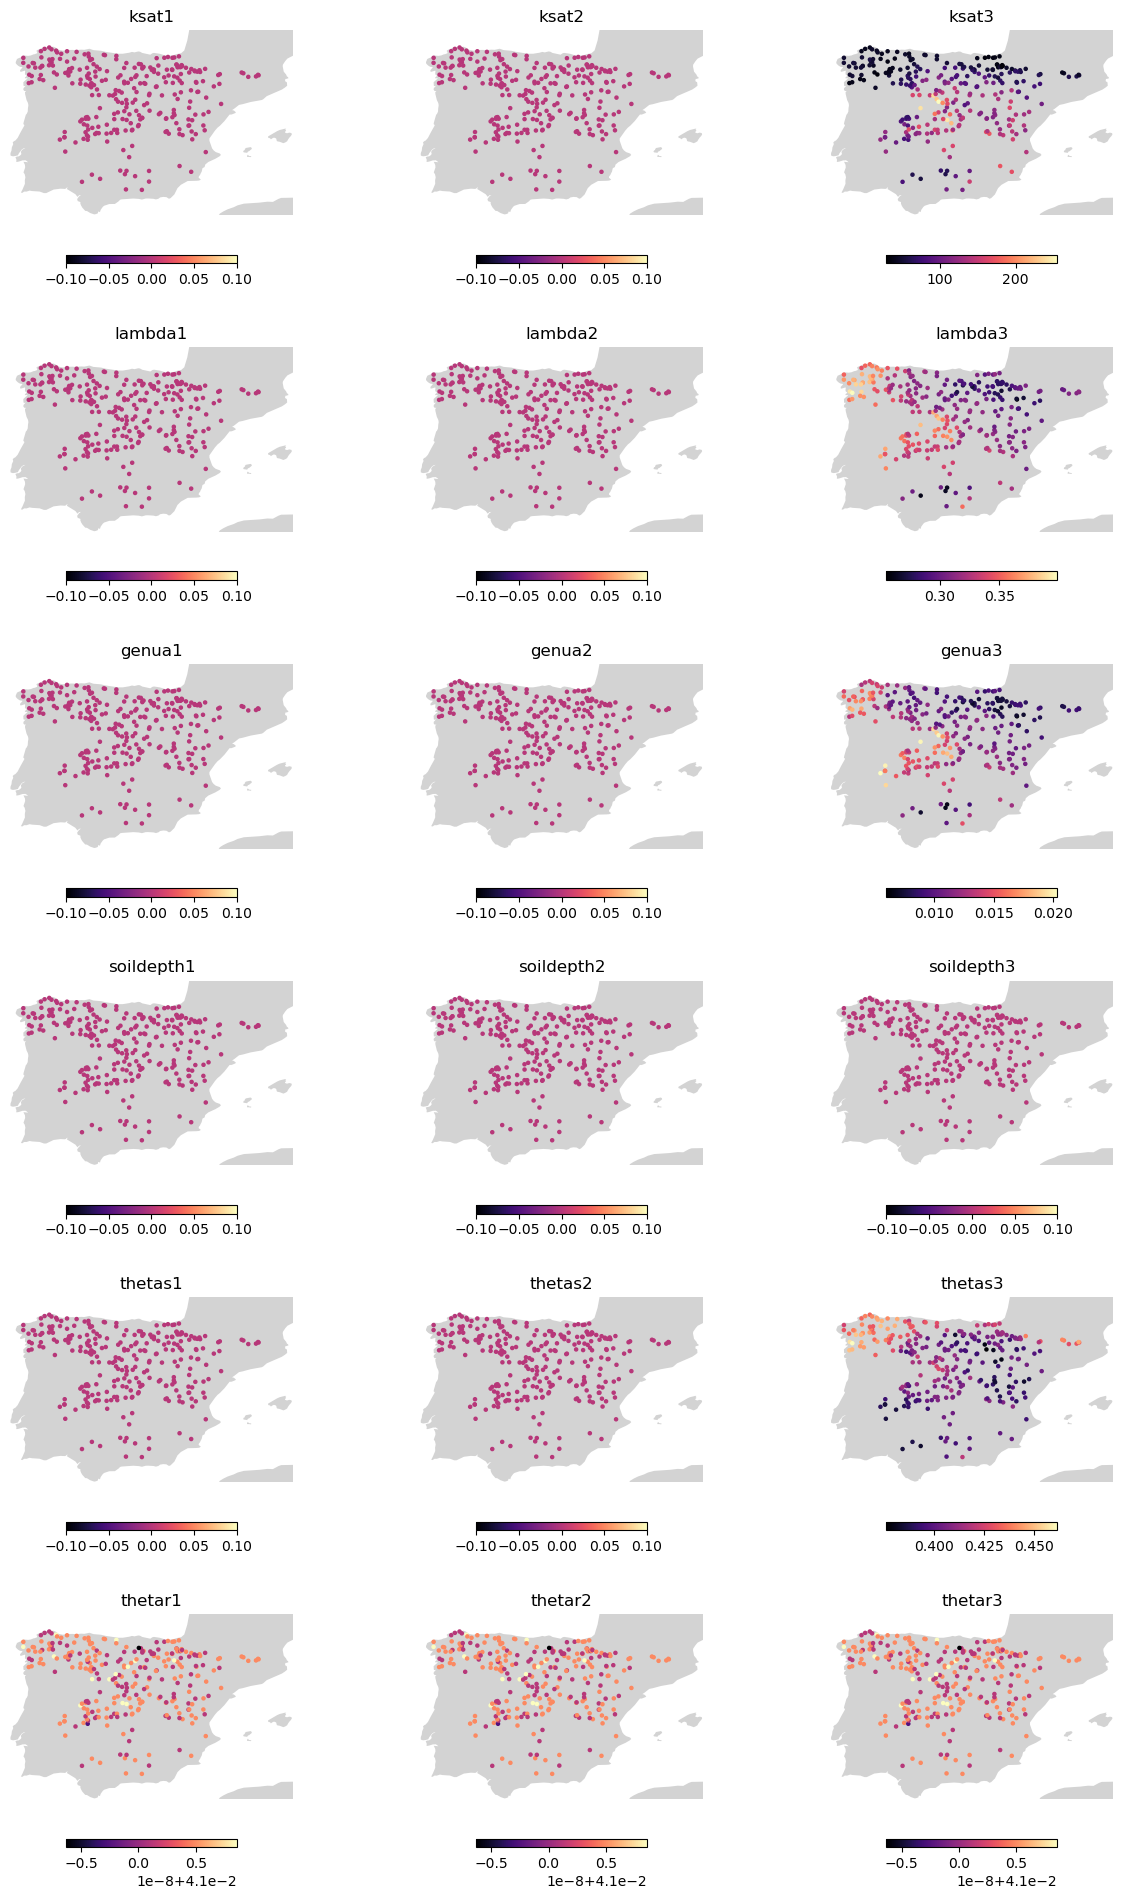

In [18]:
plot_atributos(atributos_suelos, estaciones.geometry.x, estaciones.geometry.y)

### Índice foliar

El dato original de índice foliar (_leaf area index_, LAI) es una serie con frecuencia 10 días que representa la fenología de cada uso del suelo a lo largo de un año tipo. Puesto que la idea original del LST es que los únicos datos dinámicos sean los forzamientos meteorológicos, convertiré esta serie semanal en un dato medio anual

In [19]:
maps = ['lai_f', 'lai_i', 'lai_o']

# cargar mapas
lai = xr.Dataset({var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var='Band1') for var in maps})
lai = lai.rename({var: mapping_usos[var.split('_')[1]] for var in list(lai)})
lai = lai.drop('crs')

# media ponderada por la fracción cubierta por cada uso del suelo
lai = lai.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')
lai = lai.drop('crs')

# remuestreo mensual
lai_m = lai.resample(time='1M').mean()
lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop('time') for month in lai_m.time.data})

# estadísticos anuales
lai_agg['laiyrmean'] = lai.mean('time')
lai_agg['laiyrmax'] = lai.max('time')
lai_agg['laiyrmin'] = lai.min('time')

# calcular estadístico
lai_agg = lai_agg.rio.write_crs(crs)
lai_agg = lai_agg.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
atributos_lai = polygon_statistics(lai_agg, subcuencas, func=['mean']).to_pandas()

atributos_lai.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in atributos_lai if 'mean' in col}, inplace=True)

atributos_lai.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,lai01,lai02,lai03,lai04,lai05,lai06,lai07,lai08,lai09,lai10,lai11,lai12,laiyrmean,laiyrmax,laiyrmin
id,,,,,,,,,,,,,,,
3278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


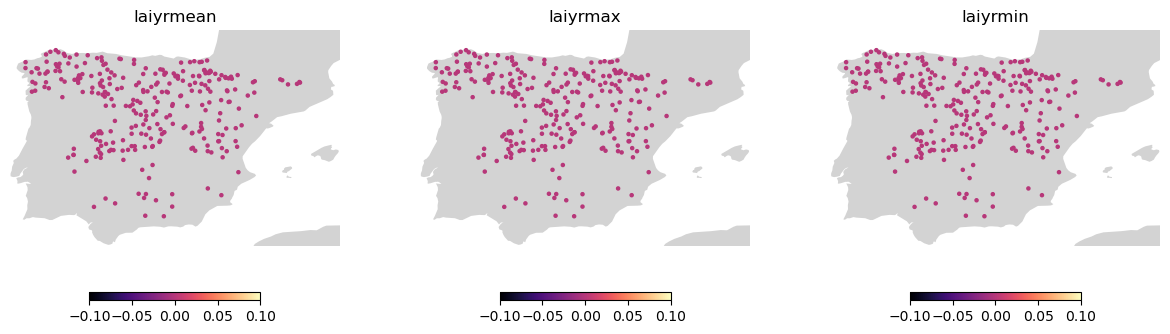

In [21]:
plot_atributos(atributos_lai[['laiyrmean', 'laiyrmax', 'laiyrmin']], estaciones.geometry.x, estaciones.geometry.y)

El procedimiento para calcular el mínimo y máximo anual no es el más correcto, puesto que pudiera darse el caso de que los máximos y mínimos de LAI en distintos usos del suelo no se produzcan al mismo tiempo durante el año. Sería más correcto calcular la serie temporal de LAI en cada cuenca y de ahí escoger el máximo y mínimo.

### Demandas

Los datos originales de demanda contienen mapas con la serie mensual de demandas (doméstica, energética, industrical y ganadera) en mm/día. Los mapas abarcan el periodo 1990-2023, con la idea de tener en cuenta el carácter cambiante de la demanda no sólo en el ciclo anual, sino también con el paso de los años.

Al igual que en el caso del LAI, calcularé una media anual para convertir estos atributos en estáticos. <font color='red'>Convertiré la demanda en mm/dia en volumen multiplicando cada celda por su área.</font>

In [22]:
maps = ['dom', 'ene', 'ind', 'liv']

# cargar mapas
demanda = xr.Dataset({var: read_static_map(f'{path_efas}/maps/{var}_*.nc', var=var) for var in maps})
demanda = demanda.drop('wgs_1984')

# media mensual
demanda_m = demanda.groupby('time.month').mean('time')

# media anual
demanda_y = demanda.groupby('time.year').mean('time').mean('year')
# demanda_y = demanda.mean('time')

# unificar en un único Dataset
demanda_ag = xr.Dataset()
for key, da in demanda_m.items():
    for month in da.month.data:
        demanda_ag[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
    demanda_ag[f'{key}_yr'] = demanda_y[key]

# calcular volumen
# demanda = demanda * 1e-3 * pixarea

# calcular estadístico
demanda_ag = demanda_ag.rio.write_crs(crs)
demanda_ag = demanda_ag.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
atributos_demanda = polygon_statistics(demanda_ag, subcuencas, func='sum').to_pandas()

atributos_demanda.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in atributos_demanda if 'sum' in col}, inplace=True)

atributos_demanda.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,dom_01,dom_02,dom_03,dom_04,dom_05,dom_06,dom_07,dom_08,dom_09,dom_10,...,liv_04,liv_05,liv_06,liv_07,liv_08,liv_09,liv_10,liv_11,liv_12,liv_yr
id,,,,,,,,,,,,,,,,,,,,,
3278,0.116765,0.106857,0.116765,0.126176,0.155588,0.169118,0.175000,0.176176,0.175000,0.168823,...,1.324412,1.515882,3.031470,3.083529,3.167940,2.086764,1.303529,0.757059,0.660000,1.625833
3169,2.157941,2.104571,2.160000,2.255000,2.343823,2.445882,2.515294,2.529117,2.512352,2.438235,...,14.330292,17.692644,30.373520,32.163223,32.620579,22.207346,15.316172,8.551174,7.270000,17.262495
3253,0.130000,0.130000,0.130000,0.130000,0.130000,0.130000,0.130000,0.130000,0.130000,0.130000,...,1.623235,2.436176,3.968234,4.250587,4.558528,3.155881,2.007646,1.259117,0.900000,2.281666
3246,0.100882,0.101714,0.100882,0.100882,0.101471,0.102647,0.102647,0.102647,0.102647,0.102647,...,2.037941,2.346176,3.877646,4.131176,4.128822,2.755587,2.245882,1.119411,1.100000,2.280833
3163,0.316765,0.295714,0.316765,0.330000,0.340882,0.344706,0.344706,0.347353,0.344706,0.344706,...,6.850293,10.060881,17.714407,18.887642,19.917936,12.788231,8.312351,4.080587,3.439999,9.443332


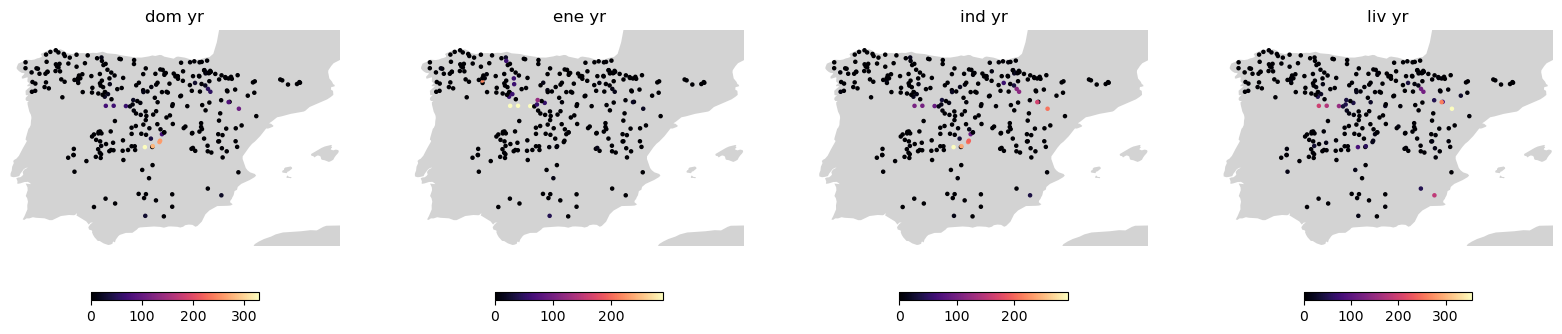

In [23]:
plot_atributos(atributos_demanda[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']], estaciones.geometry.x, estaciones.geometry.y, ncols=4)

### Embalses

In [24]:
# cargar mapa
var = 'res'
da = read_static_map(f'{path_efas}/maps/{var}_*.nc', var=var)

# extraer ID de los embalses
ids = np.unique(da)
ids = ids[~np.isnan(ids)]
print('EFAS representa {0} embalses en la zona de estudio'.format(len(ids)))

# cargar metadatos de los embalses
embalses = pd.read_csv(f'{path_efas}/tables/EFAS_HRES_reservoirs_metadata.csv')
embalses.set_index('ResID', inplace=True)

# recortar a los IDs que hay en el mapa
embalses = embalses.loc[ids, :]

# convertir en geopandas.GeoDataFrame
embalses = gpd.GeoDataFrame(embalses, geometry=[Point(xy) for xy in zip(embalses.LisfloodX, embalses.LisfloodY)])
embalses.crs = crs

# añadir atributos desde las tablas utilizadas LISFLOOD
for file in glob.glob(f'{path_efas}/tables/r*.txt'):
    var = file.split('\\')[-1].split('.')[0][1:]
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        embalses[var] = df
    except:
        print(file)
        continue

# calcular estadístico
atributos_embalses = point_polygon_statistics(embalses, subcuencas, func = {'tstor': ['sum', 'count']})
atributos_embalses.dropna(axis=1, how='all', inplace=True)
atributos_embalses.replace(np.nan, 0, inplace=True)

atributos_embalses.head()

EFAS representa 334 embalses en la zona de estudio


  0%|          | 0/287 [00:00<?, ?it/s]

,tstor_sum,tstor_count
gauge_id,,
3278,0.0,0.0
3169,0.0,0.0
3253,0.0,0.0
3246,0.0,0.0
3163,0.0,0.0


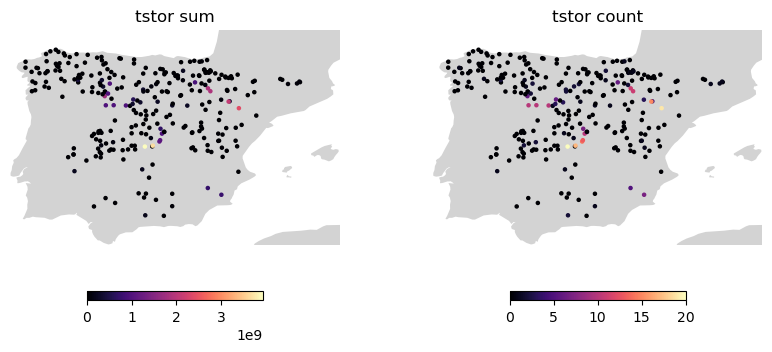

In [25]:
plot_atributos(atributos_embalses, estaciones.geometry.x, estaciones.geometry.y, ncols=2)

Crear atributo `regulacion` como el cociente entre `tstor` y el área de cuenca.

### Lagos

In [26]:
# cargar mapa
var = 'lakes'
da = read_static_map(f'{path_efas}/maps/{var}_*.nc', var=var)

# extraer ID de los embalses
ids = np.unique(da)
ids = ids[~np.isnan(ids)]
print('EFAS representa {0} lagos en la zona de estudio.'.format(len(ids)))

# cargar metadatos de los lagos
lagos = pd.read_csv(f'{path_efas}/tables/EFAS_HRES_lakes_metadata.csv')
lagos.set_index('LakID', inplace=True)

# recortar a los IDs que hay en el mapa
lagos = lagos.loc[ids, :]

# convertir en geopandas.GeoDataFrame
lagos = gpd.GeoDataFrame(lagos, geometry=[Point(xy) for xy in zip(lagos.LisfloodX, lagos.LisfloodY)])
lagos.crs = crs

# añadir atributos desde las tablas utilizadas LISFLOOD
for file in glob.glob(f'{path_efas}/tables/lake*.txt'):
    var = file.split('\\')[-1].split('.')[0][4:]
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        lagos[var] = df
    except:
        print(file)
        continue

# calcular estadístico
atributos_lagos = point_polygon_statistics(lagos, subcuencas, func={'area': ['sum', 'count']})
atributos_lagos.dropna(axis=1, how='all', inplace=True)
atributos_lagos.replace(np.nan, 0, inplace=True)

atributos_lagos.head()

EFAS representa 8 lagos en la zona de estudio.


  0%|          | 0/287 [00:00<?, ?it/s]

,area_sum,area_count
gauge_id,,
3278,0.0,0.0
3169,0.0,0.0
3253,0.0,0.0
3246,0.0,0.0
3163,0.0,0.0


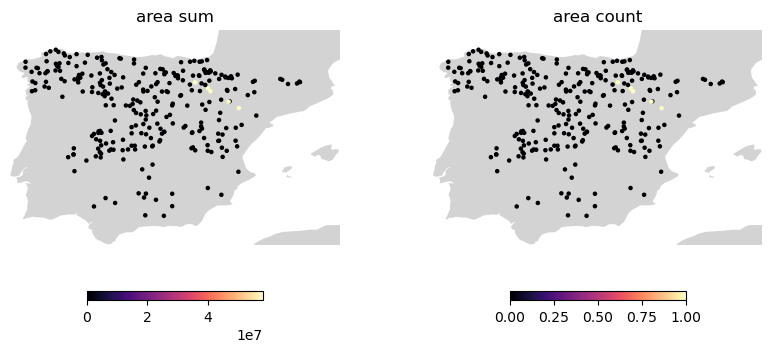

In [28]:
plot_atributos(atributos_lagos, estaciones.geometry.x, estaciones.geometry.y, ncols=2)

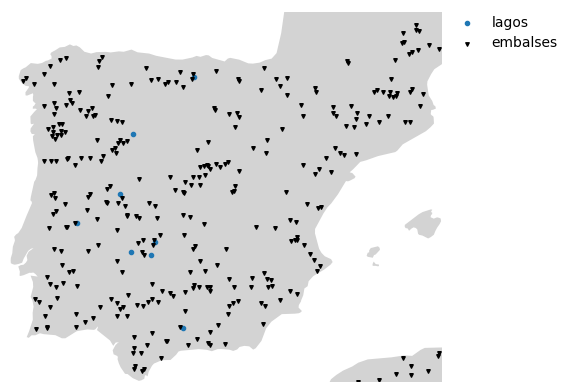

In [27]:
# plot embalses
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
lagos.plot(ax=ax, marker='.', label='lagos')
embalses.plot(ax=ax, marker='v', markersize=6, color='k', label='embalses')
ax.axis('off')
fig.legend(frameon=False, bbox_to_anchor=[.85, .6, .2, .3]);

### Exportar

In [31]:
atrs = pd.concat((atributos_cauces,
                  atributos_cultivo,
                  atributos_demanda,
                  atributos_embalses,
                  atributos_geomorfologia,
                  atributos_lagos,
                  atributos_lai,
                  atributos_suelos,
                  atributos_usos), axis=1)
atrs.index.name = 'gauge_id'
atrs.sort_index(axis=0, inplace=True)

print('{0} atributos definen las características de las {1} subcuencas'.format(*atrs.shape[::-1]))

atrs.to_csv(path_caravan / 'output/attributes/esp/atributes_efas_static_maps_esp.csv')

110 atributos definen las características de las 287 subcuencas


## Parámetros del modelo LISFLOOD

El modelo hidrológico [LISFLOOD-OS](https://github.com/ec-jrc/lisflood-code) fue calibrado para ciertos puntos en España. Como resultado se obtuvieron 14 mapas con los parámetros calibrados para cada subcuenca.

En esta sección obtendremos el valor de estos parámetros para cada una de las cuencas de estudio.

<font color='red'>Por ahora lo haré con las cuencas generadas para las estaciones seleccionadas del _Anuario de Aforos_. Lo más correcto sería que se hiciera para las subcuencas de las estaciones calibradas en EFASv5. Esto supone que hay que buscar una forma de combinar las estaciones del _Anuario de Aforos_ con las de EFASv5, quizá haya que seleccionar del _Anuario_ sólo aquéllas calibradas en EFAS.</font>

In [33]:
# listar parámetros calibrados en LISFLOOD
pars = [file.split('\\')[-1].split('.')[0] for file in glob.glob(f'{path_efas}/parameters/*.nc')]

# cargar mapas
params = xr.Dataset({par: read_static_map(f'{path_efas}/parameters/{par}.nc', var=par) for par in pars})
params = params.drop(['crs', 'spatial_ref'])

# # plot de los mapas de parámetros
# for key, da in params.items():
#     plt.figure()
#     da.plot()

# calcular estadísticos
params = params.rio.write_crs(crs)
params = params.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
parametros_lf = polygon_statistics(params, subcuencas, func='mean').to_pandas()
parametros_lf.index.name = 'gauge_id'
parametros_lf.sort_index(axis=0, inplace=True)
parametros_lf.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in parametros_lf if 'mean' in col}, inplace=True)

parametros_lf.head()

  0%|          | 0/287 [00:00<?, ?it/s]

,adjust_Normal_Flood,b_Xinanjiang,CalChanMan1,CalChanMan2,GwLoss,GwPercValue,LakeMultiplier,LowerZoneTimeConstant,LZThreshold,PowerPrefFlow,QSplitMult,ReservoirRnormqMult,SnowMeltCoef,UpperZoneTimeConstant
gauge_id,,,,,,,,,,,,,,
1080,0.790554,4.110952,1.892289,2.449084,0.042310,0.617808,1.013054,7905.989746,10.947709,0.595721,4.982800,0.993789,4.284894,8.660899
1103,0.804335,0.451254,1.621746,2.780708,0.620078,0.990826,1.017657,3956.692871,14.061962,2.916363,17.098288,0.984734,3.133822,14.402970
1105,0.800000,1.121170,1.336100,2.832396,0.809424,0.228202,1.000000,5158.322754,20.962507,2.058225,1.978903,1.000000,3.508076,3.327071
1106,0.798369,4.169017,1.912394,2.403694,0.042579,0.626943,1.002254,7932.411133,10.955438,0.550225,4.940454,0.998928,4.285839,8.775279
1109,0.800000,0.356301,1.908275,4.595753,0.454902,0.120451,1.000000,4591.135742,20.620167,3.993125,1.470608,1.000000,3.033304,5.741653


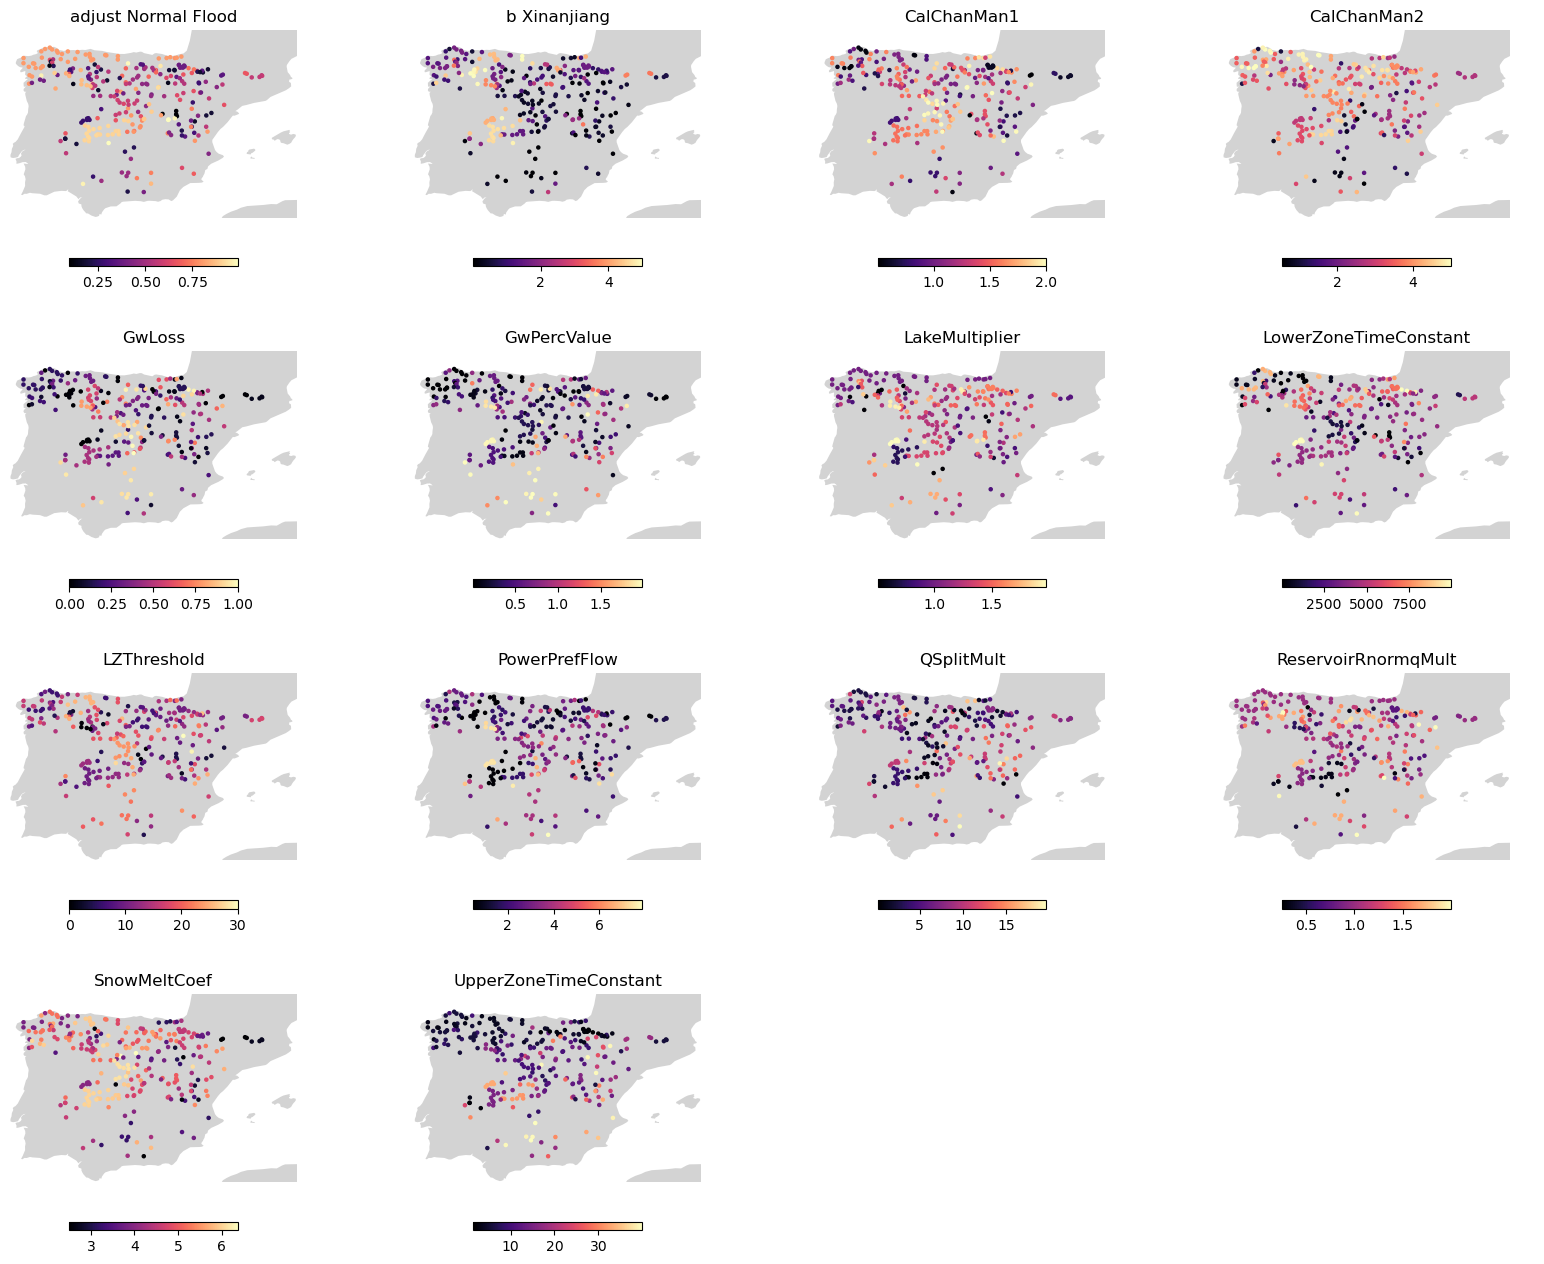

In [34]:
plot_atributos(parametros_lf, estaciones.geometry.x, estaciones.geometry.y, ncols=4)

In [36]:
print('{0} parámetros del modelo LISFLOOD fueron calibrados para las {1} subcuencas'.format(*parametros_lf.shape[::-1]))

# exportar
parametros_lf.to_csv(path_caravan / 'output/attributes/esp/atributes_efas_model_parameters_esp.csv')

14 parámetros del modelo LISFLOOD fueron calibrados para las 287 subcuencas


## Series temporales 

###  Climatología a partir de EMO-1

In [ ]:
# cargar series meteorológicas areales
meteo = xr.open_mfdataset('../data/EMO1/*.nc', chunks='auto', combine='nested', concat_dim='id')
meteo['time'] = meteo['time'] - np.timedelta64(6, 'h')

# media mensual (dato medio diario)
meteo_m = meteo.groupby('time.month').mean()
meteo_m = meteo_m.rename({'month': 'time'})
# meteo_m.time = [f'{t:02}' for t in meteo_m.time.data]

# media anual (dato medio diario)
meteo_y = meteo.mean('time')
meteo_y['time'] = ['year']

# concatenar medias mensuales y anual
meteo_ag = xr.concat((meteo_m, meteo_y), dim='time')

# renombrar la variable 'time' según se usa en CAMELS
meteo = meteo.rename({'time' : 'date'})

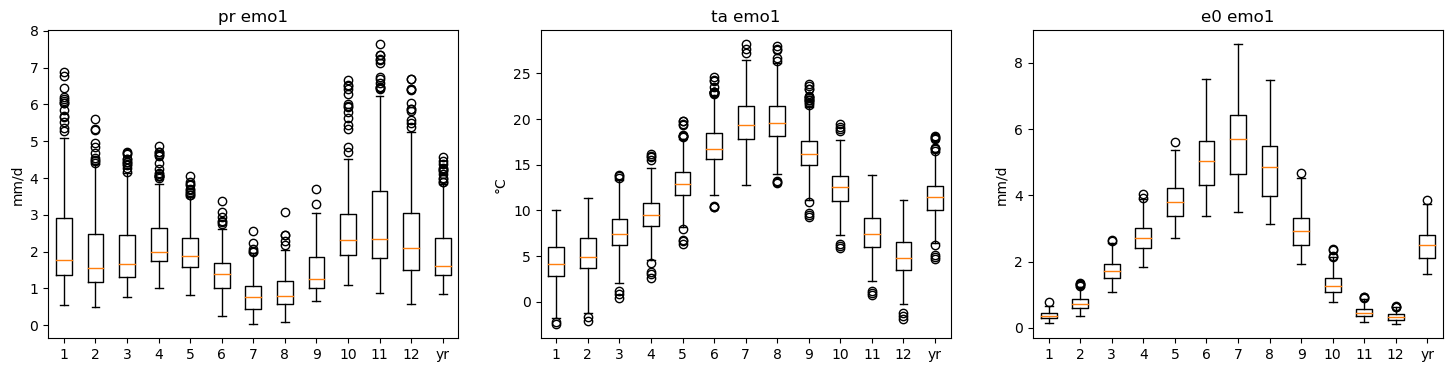

In [38]:
ncols = len(meteo)
fig, axes = plt.subplots(ncols=ncols, figsize=(6 * ncols, 4))

for ax, var in zip(axes, list(meteo)):
    mask_var = atributos_clima.columns.str.startswith(var)
    df = atributos_clima.loc[:, mask_var]
    ax.boxplot(df)
    if var in ['pr_emo1', 'e0_emo1']:
        ax.set_ylabel('mm/d')
    elif var in ['ta_emo1']:
        ax.set_ylabel('°C')
    ax.set_title(' '.join(var.split('_')))
    ax.set_xticklabels([i for i in range(1, 13)] + ['yr'])

In [39]:
# organizar en un DataFrame
atributos_clima = pd.DataFrame(index=meteo_ag.id.data)
for var, da in tqdm(meteo_ag.items()):
    # mensual
    df = da.to_pandas().transpose()
    df.columns = [f'{var}_{i:02}' if i != 'year' else f'{var}_{i}' for i in df.columns]
    # concatenar
    atributos_clima = pd.concat((atributos_clima, df), axis=1)
atributos_clima.index.name = 'gauge_id'

atributos_clima.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,pr_emo1_01,pr_emo1_02,pr_emo1_03,pr_emo1_04,pr_emo1_05,pr_emo1_06,pr_emo1_07,pr_emo1_08,pr_emo1_09,pr_emo1_10,...,e0_emo1_04,e0_emo1_05,e0_emo1_06,e0_emo1_07,e0_emo1_08,e0_emo1_09,e0_emo1_10,e0_emo1_11,e0_emo1_12,e0_emo1_year
gauge_id,,,,,,,,,,,,,,,,,,,,,
1080,4.920341,4.850715,4.127387,4.060402,3.411569,2.838983,1.997236,2.278064,2.986120,3.942675,...,2.318916,3.201094,3.767293,3.880871,3.418283,2.307398,1.221139,0.571907,0.504469,2.004816
1103,3.931179,3.717609,3.302484,2.968681,2.457960,2.084775,1.373322,1.525450,2.098503,2.866816,...,2.334771,3.247602,3.876209,4.010906,3.499129,2.310860,1.158087,0.509614,0.431366,2.008341
1105,5.652427,5.600892,4.654887,4.649866,4.064156,3.377853,2.551862,3.067790,3.706298,4.697854,...,2.388026,3.240132,3.708494,3.829872,3.419084,2.394751,1.311324,0.623725,0.564747,2.042369
1106,5.360147,5.344207,4.441845,4.409038,3.681069,3.063374,2.244384,2.447331,3.284460,4.255968,...,2.442037,3.384956,4.008262,4.173114,3.688504,2.471751,1.238601,0.538679,0.472306,2.107228
1109,4.596114,4.339185,3.816715,3.769280,3.168127,2.804241,2.012499,2.445034,3.001053,3.976716,...,2.325941,3.201638,3.714029,3.797241,3.341595,2.285949,1.236912,0.604339,0.549606,2.000786


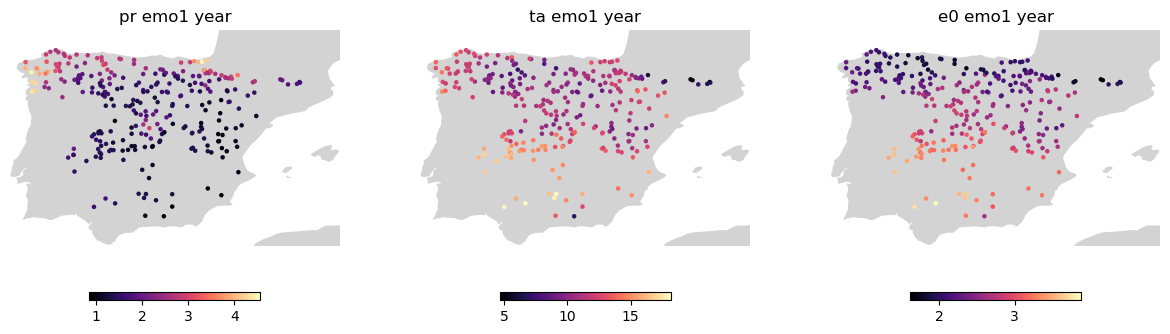

In [40]:
plot_atributos(atributos_clima[['pr_emo1_year', 'ta_emo1_year', 'e0_emo1_year']], estaciones.geometry.x, estaciones.geometry.y)

### Caudal reanálisis

In [41]:
# cargar series de caudal
dis = xr.open_dataarray('../data/EFASv5/caudal/estaciones/dis_1990_2023.nc')
dis = dis.sel(id=subcuencas.index, time=slice('1990-01-01', '2022-12-31'))
dis = dis.rename({'time' : 'date'})
dis.name = 'dis_efas5'

# calcular caudal específico
area_cuenca = xr.DataArray(estaciones.suprest).rename({'gauge_id': 'id'})
dis = dis / area_cuenca * 3.6 * 24 # mm/d

var = 'dis_efas5'
# calcular media anual del caudal mínimo, medio y máximo 
dis_y = dis.groupby('date.year')
atributos_caudal = pd.DataFrame({f'{var}_yrmean': dis_y.mean().mean('year').to_pandas(),
                                 f'{var}_yrmax': dis_y.max().mean('year').to_pandas(),
                                 f'{var}_yrmin': dis_y.min().mean('year').to_pandas()})
atributos_caudal.index.name = 'gauge_id'

atributos_caudal.head()

,dis_efas5_yrmean,dis_efas5_yrmax,dis_efas5_yrmin
gauge_id,,,
3278,0.042970,0.635972,0.004082
3169,0.301496,14.387224,0.003194
3253,0.342754,16.450519,0.000947
3246,0.324809,17.579094,0.001654
3163,1.070670,18.155500,0.003027


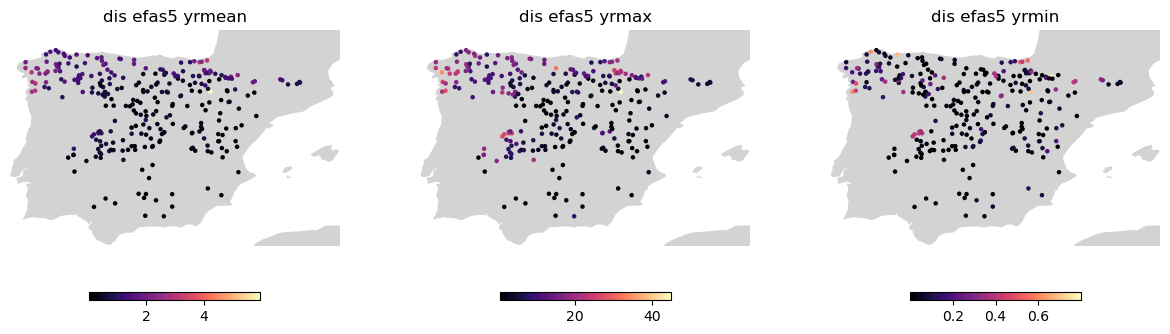

In [42]:
plot_atributos(atributos_caudal, estaciones.geometry.x, estaciones.geometry.y)

### Exportar
#### Atributos

In [45]:
atributos_hidrologia = pd.concat((atributos_clima, atributos_caudal), axis=1)

print('{0} atributos definen la hidrometeorología de las {1} subcuencas'.format(*atributos_hidrologia.shape[::-1]))

# exportar
atributos_hidrologia.to_csv(path_caravan / 'output/attributes/esp/atributes_efas_hydrometeorology_esp.csv')

42 atributos definen la hidrometeorología de las 287 subcuencas


In [46]:
atributos_hidrologia.columns

Index(['pr_emo1_01', 'pr_emo1_02', 'pr_emo1_03', 'pr_emo1_04', 'pr_emo1_05',
       'pr_emo1_06', 'pr_emo1_07', 'pr_emo1_08', 'pr_emo1_09', 'pr_emo1_10',
       'pr_emo1_11', 'pr_emo1_12', 'pr_emo1_year', 'ta_emo1_01', 'ta_emo1_02',
       'ta_emo1_03', 'ta_emo1_04', 'ta_emo1_05', 'ta_emo1_06', 'ta_emo1_07',
       'ta_emo1_08', 'ta_emo1_09', 'ta_emo1_10', 'ta_emo1_11', 'ta_emo1_12',
       'ta_emo1_year', 'e0_emo1_01', 'e0_emo1_02', 'e0_emo1_03', 'e0_emo1_04',
       'e0_emo1_05', 'e0_emo1_06', 'e0_emo1_07', 'e0_emo1_08', 'e0_emo1_09',
       'e0_emo1_10', 'e0_emo1_11', 'e0_emo1_12', 'e0_emo1_year',
       'dis_efas5_yrmean', 'dis_efas5_yrmax', 'dis_efas5_yrmin'],
      dtype='object')

#### Series temporales

**CSV**

In [138]:
files = glob.glob(f'{path_caravan}/output/timeseries/csv/esp/*.csv')
for file in tqdm(files):
    # estación
    id = str(file).split('\\')[-1].split('.')[0]
    # leer series en CAMELS
    camels = pd.read_csv(file, index_col='date', parse_dates=True)
    # extraer series de EMO1 para la estación
    emo = meteo.sel(id=id, date=camels.index.intersection(meteo.date)).drop('id').to_pandas()
    # extraer series de EFAS5 para la estacion
    efas = dis.sel(id=id, date=camels.index.intersection(dis.date)).drop('id').to_pandas()
    efas.name = 'dis_efas5'
    # concaternar todo
    camels = pd.concat((camels, emo, efas), axis=1)
    # exportar
    camels.to_csv(file.replace(f'{id:04}.csv', f'test/{id:04}.csv'))

  0%|          | 0/285 [00:00<?, ?it/s]

**NetCDF**

In [127]:
files = glob.glob(f'{path_caravan}/output/timeseries/netcdf/esp/*.nc')
for file in tqdm(files):
    # estación
    id = str(file).split('\\')[-1].split('.')[0]
    # leer series en CAMELS
    camels = xr.open_dataset(file)
    camels.close()
    # concatenar series meteorológicas
    camels = xr.merge((camels, meteo.sel(id=id).drop('id')))
    emo1_units = 'pr_emo1: observed precipitation from EMO1 [mm/d]\nta_emo1: observed air temperature from EMO1 [°C]\ne0_emo1: potential evaporation from open water from EMO1 [mm/d]\n'
    camels.attrs['Units'] += emo1_units
    # concatenar serie de caudal
    camels = xr.merge((camels, dis.sel(id=id).drop('id')))
    efas5_units = 'dis_efas5: discharge reanalysis (mm/d)\n'
    camels.attrs['Units'] += efas5_units
    # exportar
    camels.to_netcdf(file.replace(f'{id:04}.nc', f'test/{id:04}.nc'))

  0%|          | 0/285 [00:00<?, ?it/s]